# Physical Biology of the Cell- Breeding Microbial Communities

version: 6_experiment_1
Authors: Chang-Yu Chang, Jean Vila, Molly Basette, Julia Borden, Stefan Golfier, Paul Gerald Layague Sanchez, Brian von Herzen, Rachel Waymack, Xinwen Zhu, Alvaro Sanchez
Last Edited: August 22nd 2019 by Jean Vila

Notebook for implementing community level selection using the community simulator package (Marlsand et al 2019, biorxiv) .
This version perform community level selection the 'best algorithm' from the first experiment, i.e the pair_xz. to determine community phenotype we are using an additive function. We will compare this to a ctrl experiment in which communities are not selected (i.e a simple screen)

In [1]:
from IPython.display import Image
from community_simulator import *
from community_simulator.usertools import *
from community_simulator.visualization import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends import backend_pdf as bpdf
import numpy as np
import scipy as sp
colors = sns.color_palette()
%matplotlib inline

This chunk contains a set of functions and objects that you will need to perform community level selection. We are putting them all together so you can load them once and then they will be available in all subsequent chunks.  You will (hopefully) never need to change any of these functions/objects. 

In [2]:
#Make dynanmics by default we will use the Microbial consumer resource model
def dNdt(N,R,params):
    return MakeConsumerDynamics(assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

# Create a regional species pool
def RegionalSpeciesPool(assumptions):
    # Parameters
    S_tot = int(np.sum(assumptions['SA'])+assumptions['Sgen']) # Total number of species (specialist + generalist)
    F = len(assumptions['SA']) # Number of consumer families
    consumer_names = ['S'+str(k) for k in range(S_tot)]
    family_names = ['F'+str(k) for k in range(F)]
    well_names = ['W'+str(k) for k in range(assumptions['n_wells'])]
    consumer_index = [[family_names[m] for m in range(F) for k in range(assumptions['SA'][m])]
    +['GEN' for k in range(assumptions['Sgen'])],consumer_names]
    
    # Assign drawn values based on power-law distribution
    # Creating an array with M rows an n_wells columns with 0 entries
    pool = np.random.power(1, size  = S_tot) 
    return pool/np.sum(pool)  # Relative species abundance in regional pool

# Sample communities from regional species pool
def SampleFromPool(plate_N, pool, scale=10**6, inocula=10**6):
    N0 = np.zeros((plate_N.shape))
    consumer_index = plate_N.index
    well_names = plate_N.columns
    
    for k in range(plate_N.shape[1]):
        consumer_list = np.random.choice(len(pool), size=len(pool), replace=True, p=pool)
        my_tab = pd.crosstab(index=consumer_list, columns="count") # Calculate the biomass count
        N0[my_tab.index.values,k] = np.ravel(my_tab.values / np.sum(my_tab.values) * inocula / scale) # Scale to sum

    # Make data.frame
    N0 = pd.DataFrame(N0,index=consumer_index,columns=well_names)
    return N0

# Compute the distances from the target resource
def additive_community_function(plate, sigma = 0.001): #Sigma is the measurement error
    N_tot = plate.N.shape[1]
    
    # Assign additive neutral traits to each of species
    ## Number of species in pools
    S_tot = plate.N.shape[0]
    ## Assign additive traits to each species
    np.random.seed(0)
    traits = np.random.normal(0, 0.1, size=S_tot)

    return(np.sum(plate.N.values*traits[:,None],axis=0)*(1+ np.random.normal(0,sigma,N_tot)))

# Plot community function as a function of time    
def plot_community_function(function_df):
    import matplotlib.pyplot as plt
    #function_df
    time = range(0, len(function_df))
    plt.plot(time,function_df,'ko', markersize=2)
    ax = plt.gca()
    ax.set_xlabel("transfer")
    ax.set_ylabel("Community function")
    plt.show()


# Plot the transfer matrix
def plot_transfer_matrix(t):
    t    
    fig,ax=plt.subplots()
    sns.heatmap(t,ax=ax)
    ax.set_xlabel('Old well',fontsize=14)
    ax.set_ylabel('New well',fontsize=14)
    ax.set_title(r'Transfer Matrix $f$',fontsize=14)
    plt.show()
    
    
def pairwise_XZ(community_function):
    import itertools
    n = len(community_function)
    # Community function per transfer
    sorted_community_function = np.sort(community_function)
    # cutoff top ten 
    top_10 = sorted_community_function[86]
    winner_index = np.where(community_function >= top_10)
    pairwise = list(itertools.combinations(winner_index[0], 2))
    # Empty transfer matrix
    t = np.zeros((n, n))
    c=0
    for i in range (0,90): #populate rows one by one
        t[i,pairwise[c][0]]=1
        t[i,pairwise[c][1]]=1
        c = c+1
        if c == 45:
            c = 0
    c=0
    for i in range (90,96): 
        t[i,winner_index[0][c]]=1
        c = c+1
    return t

# Ctrl

This chunk below performs community assembly without any selection

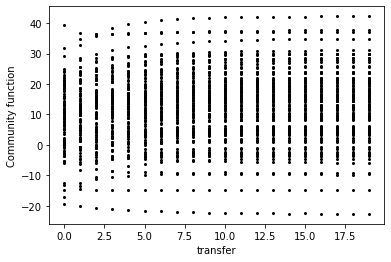

In [3]:
# Set up
np.random.seed(0) # Global random seed (i.e all participants)
n = 96 #No of wells
assumptions=a_default.copy() #Start with default parameters
assumptions.update({'n_wells':n,
                    'c1' :.01,
                    'muc':0.1, #This is just a rescaling of the uptake rate
                    'm':0}) #switch off mortality to make things simpler
init_state = MakeInitialState(assumptions)
params = MakeParams(assumptions)
species_pool = RegionalSpeciesPool(assumptions) # Generate a species pool
# Make plate
np.random.seed(0) # Unique random seed (each participant sets their own seed)
ctrl_plate = Community(init_state,dynamics,params,scale = 10**6,parallel=False) # If using mac set parallel to tru
ctrl_plate.N = SampleFromPool(ctrl_plate.N,species_pool)# Populate the well by sampling from the species pool
function_df = list()
for i in range(0,20):
    ctrl_plate.Propagate(24)
    community_function = additive_community_function(ctrl_plate)
    t = np.eye(n)*1/1000
    ctrl_plate.Passage(t)
    function_df.append(community_function)
    
# Plot the community function as a function of time 
plot_community_function(function_df)

# Community Level Selection

This chunk below performs community level selection using the pairwize_xz_function.

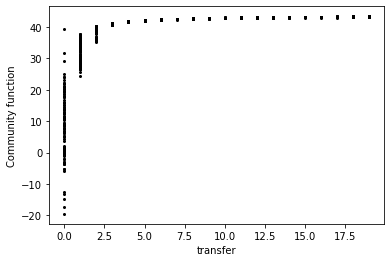

In [4]:
# Set up
np.random.seed(0) # Global random seed (i.e all participants)
n = 96 #No of wells
assumptions=a_default.copy() #Start with default parameters
assumptions.update({'n_wells':n,
                    'c1' :.01,
                    'muc':0.1, #This is just a rescaling of the uptake rate
                    'm':0}) #switch off mortality to make things simpler
init_state = MakeInitialState(assumptions)
params = MakeParams(assumptions)
species_pool = RegionalSpeciesPool(assumptions) # Generate a species pool
# Make plate
np.random.seed(0) # Unique random seed (each participant sets their own seed)
selection_plate = Community(init_state,dynamics,params,scale = 10**6,parallel=False) # If using mac set parallel to tru
selection_plate.N = SampleFromPool(selection_plate.N,species_pool)# Populate the well by sampling from the species pool
function_df = list()
for i in range(0,20):
    selection_plate.Propagate(24)
    community_function = additive_community_function(selection_plate)
    t = pairwise_XZ(community_function)*1/1000
    selection_plate.Passage(t)
    function_df.append(community_function)
    
# Plot the community function as a function of time 
plot_community_function(function_df)